## **Imports**

In [20]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import re
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import matplotlib.pyplot as plt
from torch.nn import MSELoss
import shap

## **Data Preprocessing**

In [2]:
# Load the dataset
dataset = pd.read_csv('battery_feature_extracted.csv')

In [3]:
# Select features and target
X = dataset.drop(columns=['average_voltage'])
y = dataset['average_voltage']

In [4]:
# First split to separate out the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Second split: separate the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 20% for validation


In [6]:
# Standardizing the features (fit on X_train, apply to all)
scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)  # Ensure target tensor is of the right shape
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

In [8]:
# Model parameters
num_features = X_train_scaled.shape[1]
output_size = 1  # For regression, we predict a single continuous value

# RNN with LSTM

In [9]:
# Define the LSTM-based module
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # h_n: final hidden state
        h_n = h_n[-1]  # Take the last layer's hidden state
        x = self.fc(h_n)  # Fully connected layer for output
        return x

In [10]:
# Define the TabTransformer model with LSTMNetwork
class TabTransformerWithLSTM(nn.Module):
    def __init__(self, num_features, output_size=1, dim_embedding=64, num_heads=4, num_layers=4, lstm_hidden_size=128, lstm_num_layers=1, lstm_dropout=0.5):
        super(TabTransformerWithLSTM, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, dropout=0.70)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Replace the regression layer with an LSTM-based network
        self.lstm_network = LSTMNetwork(dim_embedding, lstm_hidden_size, output_size, num_layers=lstm_num_layers, dropout=lstm_dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Adding a sequence dimension
        x = self.transformer(x)
        x = self.lstm_network(x)  # Pass through the LSTM-based network
        return x

In [11]:
# Define the model, loss function, and optimizer
model = TabTransformerWithLSTM(
    num_features=num_features,  # Input feature size
    output_size=output_size,    # Output size (1 for regression)
    dim_embedding=128,          # Embedding dimension
    num_heads=2,                # Number of attention heads
    num_layers=2,               # Number of transformer layers
    lstm_hidden_size=128,       # Hidden size for the LSTM
    lstm_num_layers=1,          # Number of LSTM layers
    lstm_dropout=0.5            # Dropout for the LSTM layers
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [12]:
# Define the model, loss function, and optimizer
model = TabTransformerWithLSTM(
    num_features=num_features,  # Input feature size
    output_size=output_size,    # Output size (1 for regression)
    dim_embedding=128,          # Embedding dimension
    num_heads=2,                # Number of attention heads
    num_layers=2,               # Number of transformer layers
    lstm_hidden_size=128,       # Hidden size for the LSTM
    lstm_num_layers=1,          # Number of LSTM layers
    lstm_dropout=0.5            # Dropout for the LSTM layers
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [13]:
# Define the composite loss function
class CompositeLoss(nn.Module):
    def __init__(self):
        super(CompositeLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()
    
    def forward(self, outputs, targets):
        mse = self.mse_loss(outputs, targets)
        mae = self.mae_loss(outputs, targets)
        return mse + 0.6 * mae  # Adjust weight as needed


In [14]:
criterion = CompositeLoss()

# Optimizer: Adam with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.00075)

# Initialize lists to store losses and accuracy for plotting
training_losses = []
validation_losses = []


In [15]:
# Training loop with validation
for epoch in range(2000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    train_loss = criterion(output, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)

    # Store the losses for plotting
    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())

    # Print training and validation loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')

Epoch 0, Training Loss: 14.857329368591309, Validation Loss: 10.714694023132324
Epoch 10, Training Loss: 7.652700901031494, Validation Loss: 3.7108585834503174
Epoch 20, Training Loss: 4.403570652008057, Validation Loss: 3.46962308883667
Epoch 30, Training Loss: 4.249546051025391, Validation Loss: 2.9056835174560547
Epoch 40, Training Loss: 3.823286771774292, Validation Loss: 2.548901081085205
Epoch 50, Training Loss: 3.3059604167938232, Validation Loss: 2.508286476135254
Epoch 60, Training Loss: 3.0050594806671143, Validation Loss: 2.2149150371551514
Epoch 70, Training Loss: 2.731419801712036, Validation Loss: 2.074796199798584
Epoch 80, Training Loss: 2.460718870162964, Validation Loss: 1.8971500396728516
Epoch 90, Training Loss: 2.278075695037842, Validation Loss: 1.8182764053344727
Epoch 100, Training Loss: 2.1916065216064453, Validation Loss: 1.6689814329147339
Epoch 110, Training Loss: 2.088042736053467, Validation Loss: 1.7840522527694702
Epoch 120, Training Loss: 1.970943212509

In [16]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    
    # Compute MSE
    test_mse = nn.MSELoss()(predictions, y_test_tensor)

    # Compute MAE
    test_mae = nn.L1Loss()(predictions, y_test_tensor)

    # Compute R²
    ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
    ss_residual = torch.sum((y_test_tensor - predictions)**2)
    r2_score = 1 - (ss_residual / ss_total)

    # Print the results
    print(f'Test MSE: {test_mse.item()}')
    print(f'Test MAE: {test_mae.item()}')
    print(f'Test R²: {r2_score.item()}')

Test MSE: 0.25880715250968933
Test MAE: 0.2747289538383484
Test R²: 0.9012453556060791


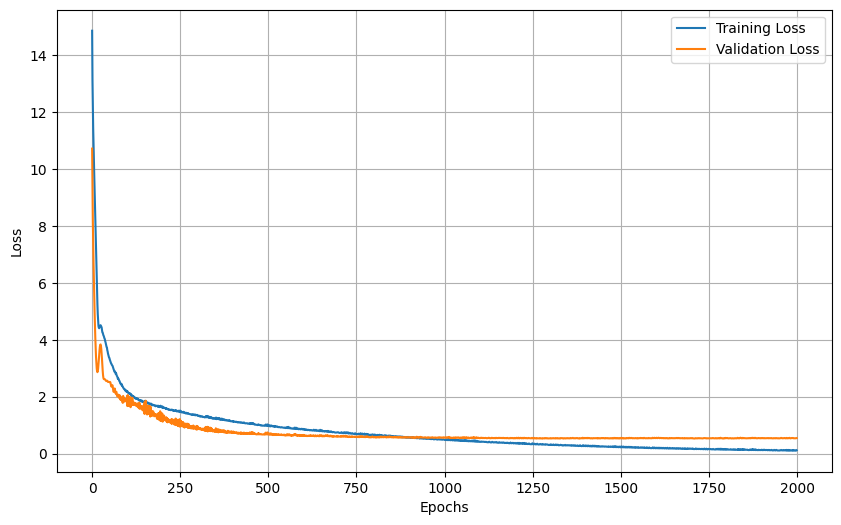

In [17]:
# Plotting the convergence curve of the loss function
plt.figure(figsize=(10, 6))
plt.plot(range(2000), training_losses, label='Training Loss')
plt.plot(range(2000), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
torch.save(model.state_dict(), 'entire_model_transformer_rnn_lstm_mae2747_mse2588_r29012.pth')
print("Model saved successfully!")

Model saved successfully!


**SHAP**

In [21]:
# Step 1: Prepare your model and move to CPU
model.eval()
device = torch.device('cpu')
model = model.to(device)

# Step 2: Define the wrapped model
def wrapped_model(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(x_tensor).cpu().numpy()
    return preds

# Step 3: Prepare SHAP data
X_train_np = X_train_tensor.cpu().numpy()
X_test_np = X_test_tensor.cpu().numpy()

# Select background and sample input
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]
X_sample = X_test_np[:50]  # Keep small for speed

# Step 4: SHAP KernelExplainer
explainer = shap.KernelExplainer(wrapped_model, background)
shap_values = explainer.shap_values(X_sample)



  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

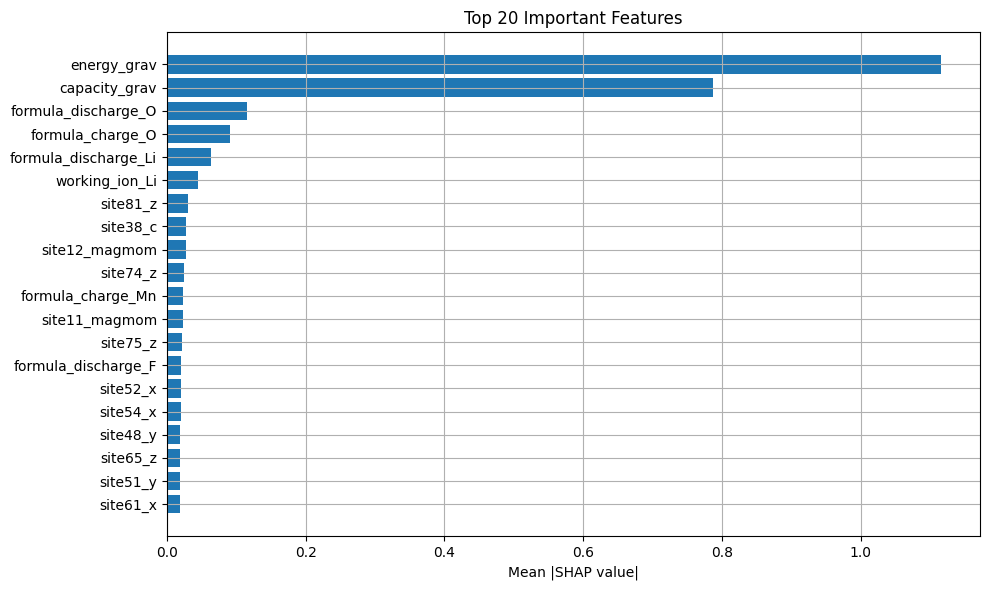

In [23]:
# Step 5: Feature importance summary
mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()  # Ensure 1D
top_indices = np.argsort(mean_abs_shap)[-20:][::-1]
feature_names = X.columns.tolist()
top_features = [feature_names[i] for i in top_indices]
top_shap_values = mean_abs_shap[top_indices]

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_shap_values)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Important Features")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()